## Agileness

### Imports

In [16]:
import numpy as np
import pandas as pd
import Directory
import os

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import itertools

In [2]:
pd.set_option('display.max_columns', None)

### Global Variables

### Get Data

### Transform the Data

### Defining team types

In [144]:
def get_team_network(n=100,type_1_count=10,type_2_count=0,type_3_count=0,strength=1):
    total_teams = type_1_count + type_2_count + type_3_count
    team_size = int(n/total_teams)
    print('Total teams = {}'.format(total_teams))
    print('Total nodes = {}'.format(n))
    print('Team size = {}'.format(team_size))
    
    if team_size%2!=0:
        raise Exception('Team size must be even')
    
    if n%total_teams != 0:
        raise Exception('The number of teams do not divide into the total number of people')
    
    group = []
    running_idx = 0
    to_connect = []

    # for each team, connect everyone (i.e. type 1)
    for type1_idx in range(1,type_1_count+1):
        for a,b in list(itertools.combinations(range(running_idx+1,running_idx + team_size+1), 2)):
            group.append([a,b,strength])
            
        running_idx = np.max(np.array(group).reshape(1,-1))
        
        to_connect.append(running_idx - 1)
    
    # for type 1, each team is connected to each other by a single edge connecting 2 nodes
    for a,b in itertools.combinations(to_connect, 2):
        group.append([a,b,strength])
        
    # for each node in these teams pair them up (i.e. type 3)
    for type3_idx in range(type_1_count+1,type_1_count+type_3_count + 1):
        team = list(range(running_idx+1,running_idx+team_size+1))
        team_a = list(filter(lambda x: x%2==0,team))
        team_b = list(filter(lambda x: x%2==1,team))
        for a,b in zip(team_a,team_b):
            group.append([a,b,strength])

        running_idx = np.max(np.array(group).reshape(1,-1))
    
    # for the rest of the nodes, connect them fully (type 2)
    team = list(range(running_idx+1,n+1))
    for a,b in list(itertools.combinations(team, 2)):
        group.append([a,b,strength])
        
    # get the max node id so far
    running_idx = np.max(np.array(group).reshape(1,-1))
        
    if (len(to_connect) > 0) and (type_2_count > 0):
        group.append([to_connect[0],running_idx-1,strength])
    
        
    print('Number of edges = {}'.format(len(group)))
    return group

In [145]:
group = get_team_network(n=100,type_1_count=2,type_2_count=8,type_3_count=0)

Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 3252


In [168]:
def get_network(group):
    demo_network = []
    degree_by_strength = []
    pagerank_by_strength = []
    between_by_strength = []
    closeness_by_strength = []
    clustering_by_strength = []
    avg_degree = []
    avg_pagerank = []
    avg_closeness = []
    avg_between = []
    avg_clustering = []
    
    df_demo = pd.DataFrame(group,columns=['ID1','ID2','StrongTieScore'])
    
    demo_network = nx.from_pandas_edgelist(df_demo, 
                            source='ID1',
                            target='ID2',
                            edge_attr='StrongTieScore' )
    
    print(nx.info(demo_network))
    
    degree_by_strength = (dict(nx.degree(demo_network,weight='StrongTieScore')))
    pagerank_by_strength = (dict(nx.pagerank(demo_network,weight='StrongTieScore')))
    between_by_strength = (dict(nx.betweenness_centrality(demo_network,weight='StrongTieScore')))
    closeness_by_strength = (dict(nx.closeness_centrality(demo_network,distance='StrongTieScore')))
    clustering_by_strength = (dict(nx.clustering(demo_network,weight='StrongTieScore')))
    avg_degree = (np.mean(list(degree_by_strength.values())))

    # get the max pagerank
    avg_pagerank = (np.mean(list(pagerank_by_strength.values())))
    avg_between = (np.mean(list(between_by_strength.values())))
    avg_closeness = (np.mean(list(closeness_by_strength.values())))
    avg_clustering = (np.mean(list(clustering_by_strength.values())))
    
    d = dict({'avg_degree':avg_degree,
             'avg_between':avg_between,
             'avg_closeness':avg_closeness,
             'avg_clustering':avg_clustering})

    return d,demo_network,{'degree_by_strength':degree_by_strength,'between_by_strength':between_by_strength,
                          'closeness_by_strength':closeness_by_strength,
                          'clustering_by_strength':clustering_by_strength}

In [227]:
df_results = None
# 0T1 10T2 0T3
t1 = 0
t2 = 10
t3 = 0

t1_list = [0,2,4,6,8,10,8,6,4,2,0]
t2_list = [10,8,6,4,2, 0,0,0,0,0,0]
t3_list = [0,0,0,0,0,  0,2,4,6,8,10]

network_dics_list = dict()
network_list = dict()

for t1,t2,t3 in list(filter(lambda x: np.sum(x)==10,itertools.product([0,2,4,6,8,10],repeat=3))):
    print('Doing {}T1_{}T2_{}T3'.format(t1,t2,t3))
    group = get_team_network(n=100,type_1_count=t1,type_2_count=t2,type_3_count=t3)
    d,network,network_dics = get_network(group)
    
    network_list['{}T1_{}T2_{}T3'.format(t1,t2,t3)] = network
    network_dics_list['{}T1_{}T2_{}T3'.format(t1,t2,t3)] = network_dics

    if df_results is None:
        df_results = pd.DataFrame(index = d.keys(),data = d.values(),columns = ['{}T1_{}T2_{}T3'.format(t1,t2,t3)]).T
    else:
        df_results = pd.concat([df_results,pd.DataFrame(index = d.keys(),data = d.values(),columns = ['{}T1_{}T2_{}T3'.format(t1,t2,t3)]).T],axis=0)

df_results['between/cluster'] = df_results['avg_between']/df_results['avg_clustering']
df_results

Doing 0T1_0T2_10T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 50
Graph with 100 nodes and 50 edges
Doing 0T1_2T2_8T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 230
Graph with 100 nodes and 230 edges
Doing 0T1_4T2_6T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 810
Graph with 100 nodes and 810 edges
Doing 0T1_6T2_4T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 1790
Graph with 100 nodes and 1790 edges
Doing 0T1_8T2_2T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 3170
Graph with 100 nodes and 3170 edges
Doing 0T1_10T2_0T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 4950
Graph with 100 nodes and 4950 edges
Doing 2T1_0T2_8T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 131
Graph with 100 nodes and 131 edges
Doing 2T1_2T2_6T3
Total teams = 10
Total nodes = 100
Team size = 10
Number of edges = 312
Graph with 100 nodes and 312 

,avg_degree,avg_between,avg_closeness,avg_clustering,between/cluster
0T1_0T2_10T3,1.00,0.000000,0.010101,0.000000,NaN
0T1_2T2_8T3,4.60,0.000000,0.046465,0.200000,0.000000
0T1_4T2_6T3,16.20,0.000000,0.163636,0.400000,0.000000
0T1_6T2_4T3,35.80,0.000000,0.361616,0.600000,0.000000
0T1_8T2_2T3,63.40,0.000000,0.640404,0.800000,0.000000
0T1_10T2_0T3,99.00,0.000000,1.000000,1.000000,0.000000
2T1_0T2_8T3,2.62,0.000371,0.027958,0.196000,0.001893
2T1_2T2_6T3,6.24,0.002309,0.072039,0.393545,0.005867
2T1_4T2_4T3,17.84,0.004288,0.178139,0.594045,0.007218
2T1_6T2_2T3,37.44,0.006267,0.354739,0.794212,0.007891


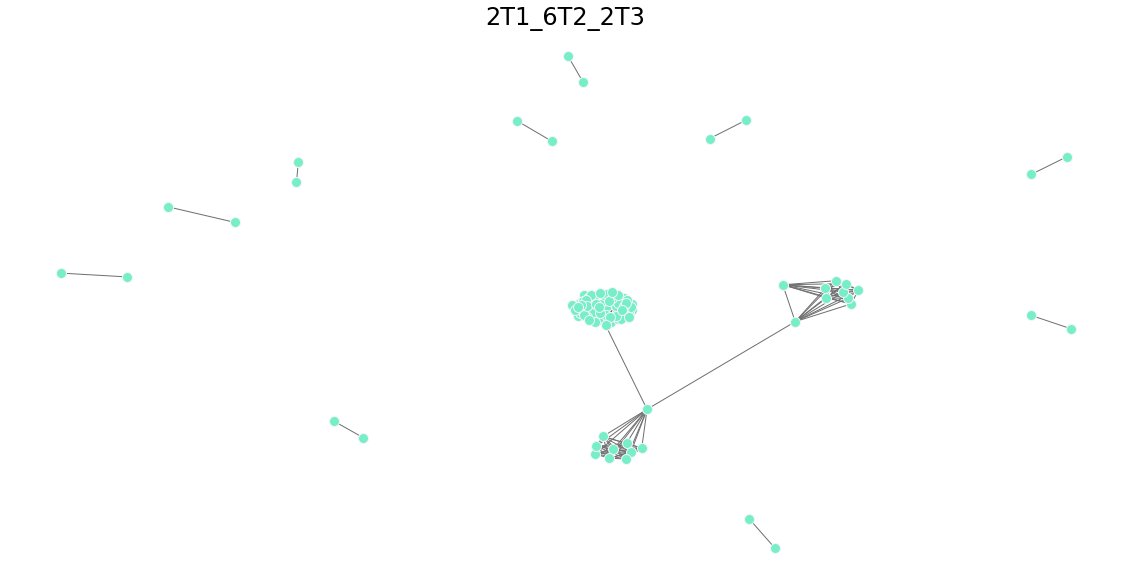

In [233]:
org_layout = '2T1_6T2_2T3'
network = network_list[org_layout]
network_dics = network_dics_list[org_layout]

pos = nx.spring_layout(network,weight='StrongTieScore',iterations=20, k = None)

dic = dict(nx.degree(network))
t = pd.DataFrame(data=dic.values(),index=dic.keys()).reset_index()
t.columns = ['Person','Degree']
t = t.sort_values(by='Degree',ascending=False)
#t = t[t['Degree']>50].copy()
most_influential=list(t['Person'])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.axis('off')
ax.set_title(org_layout,fontsize = 24)


for node in network.nodes():
    size = 100#10*network_dics['degree_by_strength'][node]
    ns = nx.draw_networkx_nodes(network,pos,nodelist=[node], node_size=size, node_color='#76eec6')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(network,pos,{n:'' for n in network.nodes() if network_dics['degree_by_strength'][n]>150},font_size=10);

for e in network.edges(data=True):
    if e[2]['StrongTieScore']>0:
        nx.draw_networkx_edges(network,pos,[e],width=e[2]['StrongTieScore'],edge_color='#707070')